In [68]:
import os
from graphgym.custom_graphgym.loader.protein import ProteinDataset

In [69]:
os.chdir('/Users/cgu3/Documents/Grape-Pi')

In [70]:
dataset = ProteinDataset("data/single", numeric_columns=['protein_probability'], label_column='hard_label', rebuild=True)
# dataset = ProteinDataset("data/yeast-ORBI", numeric_columns=['protein_probability'], label_column=None, rebuild=True)
# dataset = ProteinDataset("data/human-ORBI", numeric_columns=['protein_probability'], label_column='label', rebuild=True)

Rebuilding...
Done!


In [71]:
from matplotlib import pyplot as plt
from torch_geometric.utils import  degree
# plt.hist(degree(dataset.edge_index[0]), bins=100);

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x11a6efa30>
Traceback (most recent call last):
  File "/Users/cgu3/opt/anaconda3/envs/Grape-Pi/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/Users/cgu3/opt/anaconda3/envs/Grape-Pi/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/cgu3/opt/anaconda3/envs/Grape-Pi/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Users/cgu3/opt/anaconda3/envs/Grape-Pi/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/Users/cgu3/opt/anaconda3/envs/Grape-Pi/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/Users/cgu3/opt/anaconda3/envs/Grape-Pi/lib/python3.10/selectors

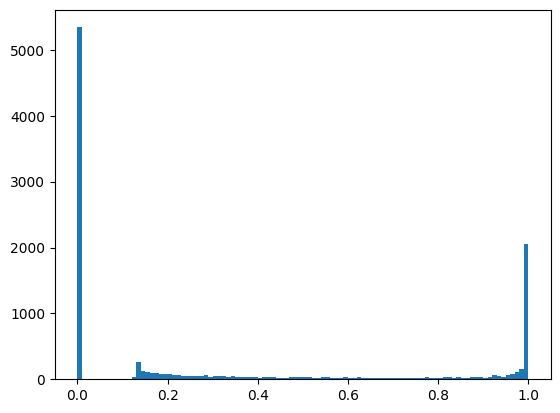

In [72]:
plt.hist(dataset.x[:, 0], bins=100);

In [73]:
dataset.num_features
# try implement this
# dataset.num_nodes

1

In [74]:
import copy
import os.path as osp
import time

import torch
import torch.nn.functional as F
from tqdm import tqdm

from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import SAGEConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = dataset[0].to(device, 'x', 'y', 'train_mask', 'val_mask', 'test_mask')

In [83]:
import torchmetrics
from torchmetrics.classification import BinaryAUROC, BinaryAccuracy, BinaryF1Score
import numpy as np

kwargs = {'batch_size': 256, 'num_workers': 4, 'persistent_workers': True}
train_loader = NeighborLoader(data, input_nodes=data.train_mask,
                              num_neighbors=[50], shuffle=True, **kwargs)

subgraph_loader = NeighborLoader(copy.copy(data), input_nodes=None,
                                 num_neighbors=[-1], shuffle=False, **kwargs)

# No need to maintain these features during evaluation:
del subgraph_loader.data.x, subgraph_loader.data.y
# Add global node index information.
subgraph_loader.data.num_nodes = data.num_nodes
subgraph_loader.data.n_id = torch.arange(data.num_nodes)


class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))
        # self.lin1 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1:
                x = x.relu_()
                # x = F.dropout(x, p=0.5, training=self.training)
            # x = self.lin1(x)
        return x

    @torch.no_grad()
    def inference(self, x_all, subgraph_loader):
        pbar = tqdm(total=len(subgraph_loader.dataset) * len(self.convs))
        pbar.set_description('Evaluating')

        # Compute representations of nodes layer by layer, using *all*
        # available edges. This leads to faster computation in contrast to
        # immediately computing the final representations of each batch:
        for i, conv in enumerate(self.convs):
            xs = []
            for batch in subgraph_loader:
                x = x_all[batch.n_id.to(x_all.device)].to(device)
                x = conv(x, batch.edge_index.to(device))
                if i < len(self.convs) - 1:
                    x = x.relu_()
                # x = self.lin1(x)
                xs.append(x[:batch.batch_size].cpu())
                pbar.update(batch.batch_size)
            x_all = torch.cat(xs, dim=0)
        pbar.close()
        return x_all


model = SAGE(dataset.num_features, 10, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

def train(epoch):
    model.train()

    pbar = tqdm(total=int(len(train_loader.dataset)))
    pbar.set_description(f'Epoch {epoch:02d}')

    total_loss = total_correct = total_examples = 0
    for batch in train_loader:
        optimizer.zero_grad()
        y = batch.y[:batch.batch_size]
        y_hat = model(batch.x, batch.edge_index.to(device))[:batch.batch_size]
        loss = F.binary_cross_entropy_with_logits(y_hat.squeeze(-1), y)
        loss.backward()
        optimizer.step()

        # total_loss += float(loss) * batch.batch_size
        # total_correct += int((y_hat.argmax(dim=-1) == y).sum())
        total_examples += batch.batch_size
        pbar.update(batch.batch_size)
    pbar.close()

    return total_loss / total_examples, total_correct / total_examples


@torch.no_grad()
def test():
    model.eval()
    logits = model.inference(data.x, subgraph_loader).squeeze(-1)
    y_pred_prob = torch.nn.functional.sigmoid(logits)
    # binary prediction
    y_pred = torch.where(y_pred_prob > 0.5, 1, 0)
    # create hard label only for confidence proteins
    y_hard = torch.where(data.y > 0.99, 1, 
                         torch.where(data.y < 0.5, 0, -1))
    binary_mask = (y_hard != -1).bool()
    y_hard = y_hard.to(y_pred_prob.device)
    y = data.y.to(y_pred_prob.device)

    
    train_auroc, val_auroc, test_auroc = BinaryAUROC(), 
    accuracy = BinaryAccuracy()
    

    accs = []
    aucs = []
    loss = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append(int((y_pred[mask] == y_hard[mask]).sum()) / int(mask.sum()))
        mask = mask & binary_mask
        aucs.append(auroc(y_pred_prob[mask], y_hard[mask]))
        loss.append(F.binary_cross_entropy_with_logits(logits[mask], y[mask]))
    
    # loss = []
    # for mask in [data.train_mask, data.val_mask, data.test_mask]:
    #     loss.append(F.binary_cross_entropy_with_logits(y_hat[mask], y[mask]))
    return loss, accs, aucs

In [84]:

times = []
for epoch in range(1, 11):
    start = time.time()
    loss, acc = train(epoch)
    # print(f'Epoch {epoch:02d}, Loss: {loss:.4f}, Approx. Train: {acc:.4f}')
    loss, accs, aucs = test()
    train_loss, val_loss, test_loss = loss
    train_acc, val_acc, test_acc = accs
    train_auc, val_auc, test_auc = aucs
    print(f'Epoch: {epoch:02d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
          f'Test Loss: {test_loss:.4f}')
    print(f'Epoch: {epoch:02d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, '
          f'Test AUC: {test_acc:.4f}')
    print(f'Epoch: {epoch:02d}, Train AUC: {train_auc:.4f}, Val AUC: {val_auc:.4f}, '
          f'Test AUC: {test_auc:.4f}')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Evaluating: 100%|██████████| 22166/22166 [00:04<00:00, 4509.99it/s] 


Epoch: 01, Train Loss: 0.6228, Val Loss: 0.6187, Test Loss: 0.6190
Epoch: 01, Train Acc: 0.6276, Val Acc: 0.6327, Test AUC: 0.6309
Epoch: 01, Train AUC: 0.8198, Val AUC: 0.8124, Test AUC: 0.8158


Evaluating: 100%|██████████| 22166/22166 [00:00<00:00, 42212.36it/s]


Epoch: 02, Train Loss: 0.5464, Val Loss: 0.5477, Test Loss: 0.5446
Epoch: 02, Train Acc: 0.7539, Val Acc: 0.7536, Test AUC: 0.7536
Epoch: 02, Train AUC: 0.8404, Val AUC: 0.8355, Test AUC: 0.8350


Evaluating: 100%|██████████| 22166/22166 [00:00<00:00, 41155.98it/s]


Epoch: 03, Train Loss: 0.4935, Val Loss: 0.4964, Test Loss: 0.4938
Epoch: 03, Train Acc: 0.7564, Val Acc: 0.7563, Test AUC: 0.7563
Epoch: 03, Train AUC: 0.8468, Val AUC: 0.8452, Test AUC: 0.8419


Evaluating: 100%|██████████| 22166/22166 [00:00<00:00, 37764.91it/s]


Epoch: 04, Train Loss: 0.4742, Val Loss: 0.4763, Test Loss: 0.4752
Epoch: 04, Train Acc: 0.7594, Val Acc: 0.7590, Test AUC: 0.7572
Epoch: 04, Train AUC: 0.8488, Val AUC: 0.8486, Test AUC: 0.8436


Evaluating: 100%|██████████| 22166/22166 [00:00<00:00, 41487.92it/s]


Epoch: 05, Train Loss: 0.4700, Val Loss: 0.4704, Test Loss: 0.4710
Epoch: 05, Train Acc: 0.7616, Val Acc: 0.7608, Test AUC: 0.7626
Epoch: 05, Train AUC: 0.8499, Val AUC: 0.8499, Test AUC: 0.8440


Evaluating: 100%|██████████| 22166/22166 [00:00<00:00, 40576.50it/s]


Epoch: 06, Train Loss: 0.4679, Val Loss: 0.4682, Test Loss: 0.4692
Epoch: 06, Train Acc: 0.7610, Val Acc: 0.7608, Test AUC: 0.7608
Epoch: 06, Train AUC: 0.8511, Val AUC: 0.8510, Test AUC: 0.8450


Evaluating: 100%|██████████| 22166/22166 [00:00<00:00, 40959.81it/s]


Epoch: 07, Train Loss: 0.4704, Val Loss: 0.4674, Test Loss: 0.4707
Epoch: 07, Train Acc: 0.7611, Val Acc: 0.7744, Test AUC: 0.7690
Epoch: 07, Train AUC: 0.8510, Val AUC: 0.8515, Test AUC: 0.8455


Evaluating: 100%|██████████| 22166/22166 [00:00<00:00, 42098.49it/s]


Epoch: 08, Train Loss: 0.4668, Val Loss: 0.4655, Test Loss: 0.4678
Epoch: 08, Train Acc: 0.7637, Val Acc: 0.7635, Test AUC: 0.7608
Epoch: 08, Train AUC: 0.8522, Val AUC: 0.8526, Test AUC: 0.8467


Evaluating: 100%|██████████| 22166/22166 [00:00<00:00, 40794.46it/s]


Epoch: 09, Train Loss: 0.4672, Val Loss: 0.4648, Test Loss: 0.4678
Epoch: 09, Train Acc: 0.7617, Val Acc: 0.7708, Test AUC: 0.7635
Epoch: 09, Train AUC: 0.8525, Val AUC: 0.8528, Test AUC: 0.8469


Evaluating: 100%|██████████| 22166/22166 [00:00<00:00, 41448.21it/s]

Epoch: 10, Train Loss: 0.4663, Val Loss: 0.4637, Test Loss: 0.4668
Epoch: 10, Train Acc: 0.7623, Val Acc: 0.7708, Test AUC: 0.7617
Epoch: 10, Train AUC: 0.8527, Val AUC: 0.8536, Test AUC: 0.8475
Median time per epoch: 0.8943s
